In [1]:
import sys
import os

tangram2_path = "/gstore/home/huangh83/merge_request/tangram2/src/" # <--- **CHANGE THIS**

# Add the path to sys.path
sys.path.insert(0, tangram2_path) # Using insert(0, ...) puts it at the beginning,
                                     # ensuring it's found before other potentially
                                     # installed versions or similarly named modules.

# Now you can import your package as if it were installed
sys.path.append("../../../../../Tangram")

## Deconvolution benchmark
<br>
<b>Description</b> : In this notebook we plot the deconvolution acuracy comparison among Tangram, Tangram 2 cell level mapping and Tangram 2 integrate mapping. The comparisons are done on simulated datasets (perfectly paired, paired, unpaired). The results are plotted in Figure 2c <br>
<b>Author</b> : Hejin Huang (huang.hejin@gene.com)<br>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad # Used for AnnData objects
import tangram2 as tg2
import tangram as tg
from sklearn.metrics.pairwise import cosine_similarity

/gstore/home/huangh83/miniconda3/envs/tangram/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /gstore/home/huangh83/miniconda3/envs/tangram/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warn(f"Failed to load image Python extension: {e}")


In [3]:
# Load AnnData objects
ad_sp = sc.read_h5ad('/gstore/data/resbioai/tangram2_data/telegraph/res/deconvolution/ad_sp.h5ad')
ad_sc_paired = sc.read_h5ad('/gstore/data/resbioai/tangram2_data/telegraph/res/deconvolution/ad_sc_paired.h5ad')
ad_sc_paired_unperfect = sc.read_h5ad('/gstore/data/resbioai/tangram2_data/telegraph/res/deconvolution/ad_sc_paired_unperfect.h5ad')
ad_sc_original = sc.read_h5ad('/gstore/data/resbioai/tangram2_data/telegraph/res/ccc_data/original_dataset/bc.h5ad') # Renamed to avoid conflict
ad_sc_unpaired = ad_sc_original[(ad_sc_original.obs['orig.ident'] != 'CID44971') * (ad_sc_original.obs['subtype'] == 'TNBC')]

# Define the label column used for cell types
cell_type_label_column = 'celltype_major'

# Group AnnData objects for different mapping scenarios
ad_sc_group = {
    'perfectly paired': ad_sc_paired,
    'paired': ad_sc_paired_unperfect,
    'unpaired': ad_sc_unpaired
}

In [4]:
# --- Initialize Dictionaries for Deconvolution Results ---
deconvolution_tg2_cell = {}
deconvolution_tg2_integrate = {}
deconvolution_tg1_cell = {}

# --- Loop through different single-cell groups for deconvolution ---
for key in ad_sc_group: # Changed to iterate directly over ad_sc_group keys
    print(f"Processing group: {key}") # Added print statement for clarity

    ## Obtain results for Tangram2 integrate mode
    # Create copies to avoid modifying original AnnDatas
    ad_sc_mapping_tg2_integrate = ad_sc_group[key].copy()
    ad_sp_mapping_tg2_integrate = ad_sp.copy()

    # Preprocessing for Tangram2 integrate
    sc.pp.normalize_total(ad_sc_mapping_tg2_integrate, target_sum=1E4)
    tg2.mapping.pp_adatas(ad_sc_mapping_tg2_integrate, ad_sp_mapping_tg2_integrate) # Changed tan2 to tg2

    # Run Tangram2 mapping in integrate mode
    ad_map_tg2_integrate, _ = tg2.mapping.map_cells_to_space( # Changed tan2 to tg2
        ad_sc_mapping_tg2_integrate,
        ad_sp_mapping_tg2_integrate,
        mode="integrate",
        device='cuda:0',
        density_prior='uniform',
        cluster_label = cell_type_label_column, # Use the defined label column
    )
    
    # Project cell annotations to get cell type compositions
    tg2.mapping.project_cell_annotations(ad_map_tg2_integrate, ad_sp_mapping_tg2_integrate, annotation=cell_type_label_column) # Changed tan2 to tg2
    deconvolution_tg2_integrate[key] = ad_sp_mapping_tg2_integrate.obsm['tangram_ct_pred'].copy() # Store a copy
    
    #tangram2 cell mode
    ad_sc_mapping_tg2_cell = ad_sc_group[key].copy()
    ad_sp_mapping_tg2_cell = ad_sp.copy()
    sc.pp.normalize_total(ad_sc_mapping_tg2_cell, target_sum=1E4)
    
    tg2.mapping.pp_adatas(ad_sc_mapping_tg2_cell, ad_sp_mapping_tg2_cell) # Changed tan2 to tg2

    ad_map_tg2_cell = tg2.mapping.map_cells_to_space( # Changed tan2 to tg2
        ad_sc_mapping_tg2_cell,
        ad_sp_mapping_tg2_cell,
        mode="cells",
        device='cuda:0',
        density_prior='uniform',
    )

    tg2.mapping.project_cell_annotations(ad_map_tg2_cell, ad_sp_mapping_tg2_cell, annotation=cell_type_label_column) # Changed tan2 to tg2
    deconvolution_tg2_cell[key] = ad_sp_mapping_tg2_cell.obsm['tangram_ct_pred'].copy() # Store a copy
    
    #tangram1 cell mode    
    ad_sc_mapping_tg1_cell = ad_sc_group[key].copy()
    ad_sp_mapping_tg1_cell = ad_sp.copy()
    sc.pp.normalize_total(ad_sc_mapping_tg1_cell, target_sum=1E4)
    
    tg.pp_adatas(ad_sc_mapping_tg1_cell, ad_sp_mapping_tg1_cell) # Changed tan to tg

    ad_map_tg1_cell = tg.map_cells_to_space( # Changed tan to tg
        ad_sc_mapping_tg1_cell,
        ad_sp_mapping_tg1_cell,
        mode="cells",
        device='cuda:0',
        density_prior='uniform',
    )

    tg.project_cell_annotations(ad_map_tg1_cell, ad_sp_mapping_tg1_cell, annotation=cell_type_label_column) # Changed tan to tg
    deconvolution_tg1_cell[key] = ad_sp_mapping_tg1_cell.obsm['tangram_ct_pred'].copy()

Processing group: perfectly paired


INFO:root:22389 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:22389 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 22389 genes and uniform density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.869, KL reg: 2.279, Entropy reg: -7.492
Score: 0.951, KL reg: 2.197, Entropy reg: -6.461
Score: 0.952, KL reg: 2.197, Entropy reg: -6.364
Score: 0.953, KL reg: 2.197, Entropy reg: -6.325
Score: 0.953, KL reg: 2.197, Entropy reg: -6.301
Score: 0.953, KL reg: 2.197, Entropy reg: -6.284
Score: 0.953, KL reg: 2.197, Entropy reg: -6.273
Score: 0.953, KL reg: 2.197, Entropy reg: -6.267
Score: 0.953, KL reg: 2.197, Entropy reg: -6.263
Score: 0.953, KL reg: 2.197, Entropy reg: -6.261


INFO:root:Renormalizing Single cell data
INFO:root:Begin training with 22389 genes and uniform density_prior in cells mode after renormalization
INFO:root:Printing scores every 100 epochs.


Score: 0.903, KL reg: 0.000, Entropy reg: -17781.992
Score: 0.989, KL reg: 0.000, Entropy reg: -2995.026
Score: 0.990, KL reg: 0.000, Entropy reg: -2446.116
Score: 0.990, KL reg: 0.000, Entropy reg: -2307.570
Score: 0.990, KL reg: 0.000, Entropy reg: -2246.527
Score: 0.990, KL reg: 0.000, Entropy reg: -2210.698
Score: 0.990, KL reg: 0.000, Entropy reg: -2192.285
Score: 0.990, KL reg: 0.000, Entropy reg: -2179.195
Score: 0.990, KL reg: 0.000, Entropy reg: -2169.795
Score: 0.990, KL reg: 0.000, Entropy reg: -2155.658


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.
INFO:root:22389 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:22389 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 22389 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.898, KL reg: 0.000, Entropy reg: -17779.312
Score: 0.987, KL reg: 0.000, Entropy reg: -3197.952
Score: 0.988, KL reg: 0.000, Entropy reg: -2582.561
Score: 0.988, KL reg: 0.000, Entropy reg: -2444.964
Score: 0.988, KL reg: 0.000, Entropy reg: -2383.346
Score: 0.988, KL reg: 0.000, Entropy reg: -2350.531
Score: 0.988, KL reg: 0.000, Entropy reg: -2328.988
Score: 0.988, KL reg: 0.000, Entropy reg: -2319.648
Score: 0.988, KL reg: 0.000, Entropy reg: -2313.886
Score: 0.988, KL reg: 0.000, Entropy reg: -2305.399


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.
INFO:root:22389 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:22389 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 22389 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.367, KL reg: 0.000
Score: 0.921, KL reg: 0.013
Score: 0.922, KL reg: 0.012
Score: 0.923, KL reg: 0.012
Score: 0.923, KL reg: 0.012
Score: 0.923, KL reg: 0.012
Score: 0.923, KL reg: 0.012
Score: 0.923, KL reg: 0.012
Score: 0.923, KL reg: 0.012
Score: 0.923, KL reg: 0.012


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


Processing group: paired


INFO:root:20930 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:20930 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 20930 genes and uniform density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.863, KL reg: 2.280, Entropy reg: -7.466
Score: 0.949, KL reg: 2.197, Entropy reg: -6.506
Score: 0.951, KL reg: 2.197, Entropy reg: -6.377
Score: 0.951, KL reg: 2.197, Entropy reg: -6.327
Score: 0.951, KL reg: 2.197, Entropy reg: -6.308
Score: 0.951, KL reg: 2.197, Entropy reg: -6.296
Score: 0.951, KL reg: 2.197, Entropy reg: -6.287
Score: 0.951, KL reg: 2.197, Entropy reg: -6.280
Score: 0.951, KL reg: 2.197, Entropy reg: -6.275
Score: 0.951, KL reg: 2.197, Entropy reg: -6.268


INFO:root:Renormalizing Single cell data
INFO:root:Begin training with 20930 genes and uniform density_prior in cells mode after renormalization
INFO:root:Printing scores every 100 epochs.


Score: 0.903, KL reg: 0.000, Entropy reg: -21254.689
Score: 0.959, KL reg: 0.000, Entropy reg: -12628.223
Score: 0.960, KL reg: 0.000, Entropy reg: -11642.691
Score: 0.960, KL reg: 0.000, Entropy reg: -11338.322
Score: 0.960, KL reg: 0.000, Entropy reg: -11193.051
Score: 0.960, KL reg: 0.000, Entropy reg: -11113.234
Score: 0.960, KL reg: 0.000, Entropy reg: -11064.778
Score: 0.960, KL reg: 0.000, Entropy reg: -11031.328
Score: 0.960, KL reg: 0.000, Entropy reg: -11009.955
Score: 0.960, KL reg: 0.000, Entropy reg: -10994.371


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.
INFO:root:20930 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:20930 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 20930 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.896, KL reg: 0.000, Entropy reg: -21250.992
Score: 0.957, KL reg: 0.000, Entropy reg: -12327.979
Score: 0.958, KL reg: 0.000, Entropy reg: -11452.957
Score: 0.958, KL reg: 0.000, Entropy reg: -11195.301
Score: 0.958, KL reg: 0.000, Entropy reg: -11082.129
Score: 0.958, KL reg: 0.000, Entropy reg: -11020.836
Score: 0.958, KL reg: 0.000, Entropy reg: -10984.001
Score: 0.958, KL reg: 0.000, Entropy reg: -10960.533
Score: 0.958, KL reg: 0.000, Entropy reg: -10944.330
Score: 0.958, KL reg: 0.000, Entropy reg: -10934.588


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.
INFO:root:20930 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:20930 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 20930 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.390, KL reg: 0.000
Score: 0.669, KL reg: 0.016
Score: 0.670, KL reg: 0.016
Score: 0.670, KL reg: 0.016
Score: 0.670, KL reg: 0.016
Score: 0.670, KL reg: 0.016
Score: 0.671, KL reg: 0.016
Score: 0.671, KL reg: 0.016
Score: 0.671, KL reg: 0.016
Score: 0.671, KL reg: 0.016


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


Processing group: unpaired


INFO:root:22147 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:22147 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 22147 genes and uniform density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.842, KL reg: 2.276, Entropy reg: -7.505
Score: 0.913, KL reg: 2.197, Entropy reg: -6.559
Score: 0.915, KL reg: 2.197, Entropy reg: -6.461
Score: 0.915, KL reg: 2.197, Entropy reg: -6.425
Score: 0.915, KL reg: 2.197, Entropy reg: -6.404
Score: 0.915, KL reg: 2.197, Entropy reg: -6.391
Score: 0.915, KL reg: 2.197, Entropy reg: -6.384
Score: 0.915, KL reg: 2.197, Entropy reg: -6.376
Score: 0.915, KL reg: 2.197, Entropy reg: -6.371
Score: 0.915, KL reg: 2.197, Entropy reg: -6.367


INFO:root:Renormalizing Single cell data
INFO:root:Begin training with 22147 genes and uniform density_prior in cells mode after renormalization
INFO:root:Printing scores every 100 epochs.


Score: 0.882, KL reg: 0.000, Entropy reg: -182617.875
Score: 0.932, KL reg: 0.000, Entropy reg: -54264.480
Score: 0.934, KL reg: 0.000, Entropy reg: -31336.266
Score: 0.935, KL reg: 0.000, Entropy reg: -27487.957
Score: 0.935, KL reg: 0.000, Entropy reg: -26038.156
Score: 0.935, KL reg: 0.000, Entropy reg: -25297.982
Score: 0.935, KL reg: 0.000, Entropy reg: -24893.490
Score: 0.935, KL reg: 0.000, Entropy reg: -24632.598
Score: 0.935, KL reg: 0.000, Entropy reg: -24493.836
Score: 0.935, KL reg: 0.000, Entropy reg: -24365.203


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.
INFO:root:22147 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:22147 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 22147 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.863, KL reg: 0.000, Entropy reg: -182612.406
Score: 0.924, KL reg: 0.000, Entropy reg: -54183.152
Score: 0.926, KL reg: 0.000, Entropy reg: -35042.094
Score: 0.926, KL reg: 0.000, Entropy reg: -31022.129
Score: 0.927, KL reg: 0.000, Entropy reg: -29442.148
Score: 0.927, KL reg: 0.000, Entropy reg: -28582.812
Score: 0.927, KL reg: 0.000, Entropy reg: -28130.826
Score: 0.927, KL reg: 0.000, Entropy reg: -27873.617
Score: 0.927, KL reg: 0.000, Entropy reg: -27706.547
Score: 0.927, KL reg: 0.000, Entropy reg: -27593.922


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.
INFO:root:22147 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:22147 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 22147 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.378, KL reg: 0.000
Score: 0.747, KL reg: 0.016
Score: 0.752, KL reg: 0.015
Score: 0.753, KL reg: 0.015
Score: 0.753, KL reg: 0.015
Score: 0.754, KL reg: 0.015
Score: 0.754, KL reg: 0.015
Score: 0.754, KL reg: 0.015
Score: 0.754, KL reg: 0.015
Score: 0.754, KL reg: 0.015


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


<Figure size 640x480 with 0 Axes>

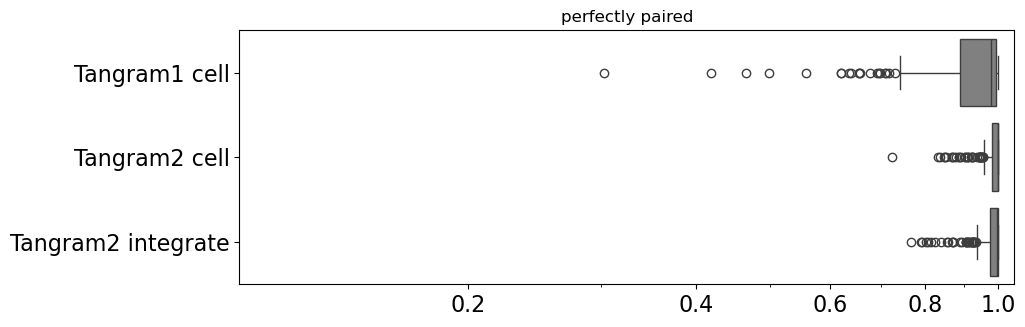

<Figure size 640x480 with 0 Axes>

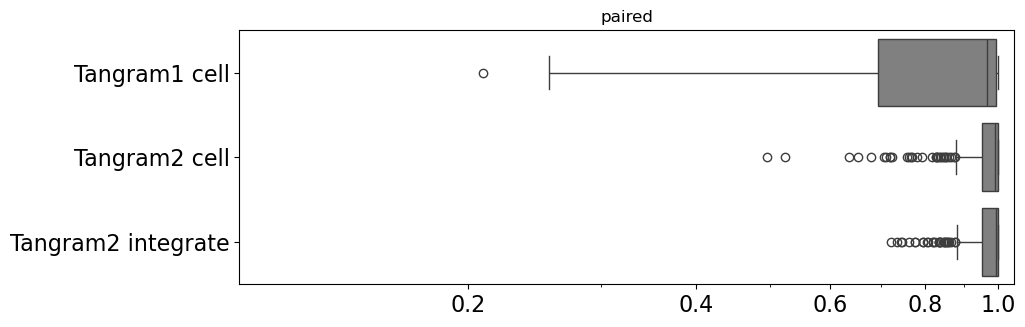

<Figure size 640x480 with 0 Axes>

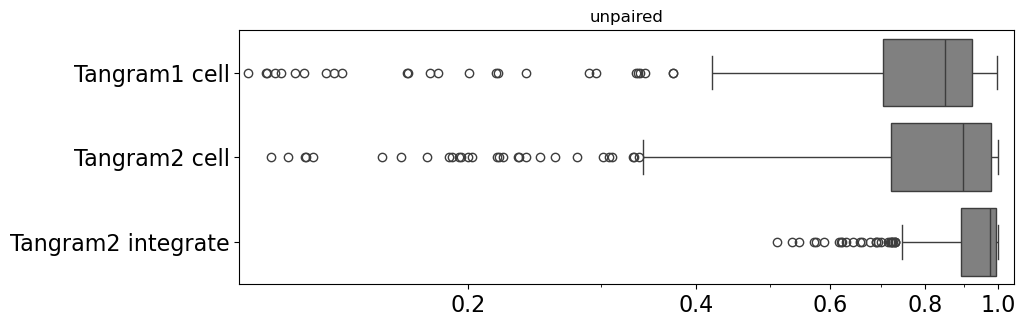

In [5]:
result_df = pd.DataFrame(index = ad_sp.obs.index) # Initialize DataFrame for results
order = ad_sp.obsm['ct_counts'].columns # Get the order of cell types

for key in ad_sc_group: 
    composition = deconvolution_tg1_cell[key]
    cos = cosine_similarity(composition[order].values, ad_sp.obsm['ct_proportions'].values)
    result_df['Tangram1 cell'] = cos.diagonal()
    
    composition = deconvolution_tg2_cell[key]
    cos = cosine_similarity(composition[order].values, ad_sp.obsm['ct_proportions'].values)
    result_df['Tangram2 cell'] = cos.diagonal()
    
    composition = deconvolution_tg2_integrate[key]
    cos = cosine_similarity(composition[order].values, ad_sp.obsm['ct_proportions'].values)
    result_df['Tangram2 integrate'] = cos.diagonal()
    
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 3.3))
    sns.boxplot(result_df[['Tangram1 cell', 'Tangram2 cell', 'Tangram2 integrate']], orient='h', color='grey', ax=ax)
    plt.xticks(fontsize=16) #rotation=45, 
    plt.yticks(fontsize=16)
    plt.xscale('log')
    plt.title(key)
    ax.set_xlim([0.1, 1.05])  # Start from 0.2 since 0 cannot be represented on log scale
    desired_ticks = [0.2, 0.4, 0.6, 0.8, 1.0]
    ax.set_xticks(desired_ticks)
    ax.set_xticklabels(['0.2', '0.4',  '0.6', '0.8', '1.0'])
    plt.show()